In [1]:
# Initialize Otter
import otter
grader = otter.Notebook()

# Homework 7: Gradient Descent, Logistic Regression
## Due Date:  Thursday Nov 12, 11:59 PM

## This Assignment

This assignment consists of 2 parts. In these parts, we will:

1. Implement gradient descent, and show how it can be used to minimize differentiable functions, even including loss functions for non-linear models.
1. Fit a logistic regression model on NBA data.


Note that the first part of this assignment will use bold notation to represent vectors, i.e. $\mathbf{x}$.

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the assignment, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

**Collaborators:** ...

## Point Distribution
| Question | Points | 
|----------|--------|
| 1 | 1 |
| 2a | 2 |
| 2b | 2 |
| 3a | 2 |
| 3b | 2 |
| 3c | 1 |
| 4a | 1 |
| 4b | 1 |
| 4c | 1 |
| 5a | 1 |
| 5b | 1 |
| 5c | 1 |
| 6a | 1 |
| 6b | 1 |
| 6c | 1 |
| 6d | 1 |
| 7a | 1 |
| 7b | 1 |
| 7c | 1 |
| Total | 23 | 

# Part 1: Gradient Descent

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import seaborn as sns
import sklearn
import sklearn.datasets
import sklearn.linear_model

np.random.seed(42)
plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")

# Set some parameters
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 16
np.set_printoptions(4)

# We will use plot_3d helper function to help us visualize gradients
from hw7_utils import plot_3d

%matplotlib inline

C:\Users\John8\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\John8\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.o

## Load Data
Load the data.csv file into a pandas dataframe.  
Note that we are reading the data directly from the URL address.

In [215]:
# Run this cell to load our sample data
part_1_data = pd.read_csv("https://github.com/DS-100/su20/raw/gh-pages/resources/assets/datasets/hw7_data.csv", index_col=0)
part_1_data.head()

,x,y
0,-5.000000,-7.672309
1,-4.966555,-7.779735
2,-4.933110,-7.995938
3,-4.899666,-8.197059
4,-4.866221,-8.183883


---
## A Simple Model
Let's start by examining our data and creating a simple model that can represent this data.

First, run the cell below to visualize our data.

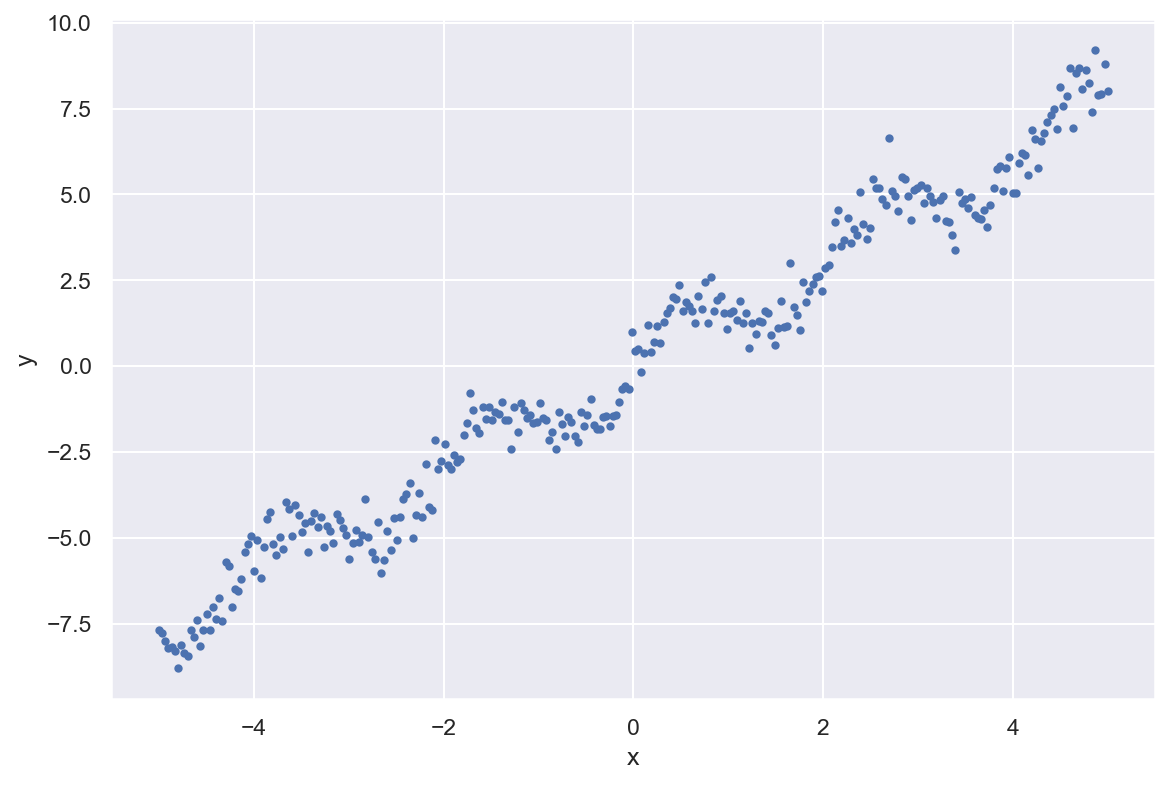

In [216]:
def scatter(x, y):
    """
    Generate a scatter plot using x and y

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, marker='.')
    plt.xlabel('x')
    plt.ylabel('y')
    
x = part_1_data['x']
y = part_1_data['y']
scatter(x,y)

The data looks roughly linear, with some extra sinusoidal noise. For now, let's assume that the data follows some underlying linear model. We define the underlying linear model that predicts the value $y$ using the value $x$ as: $f_{\theta^*}(x) = \theta^* \cdot x$

Since we cannot find the value of the population parameter $\theta^*$ exactly, we will assume that our dataset approximates our population and use our dataset to estimate $\theta^*$. We denote an estimate with $\theta$ and the fitted estimated chosen based on the data as $\hat{\theta}$. Our parameterized model is:

$$\Large
f_{\theta}(x) = \theta \cdot x
$$

Based on this equation, we will define the linear model function `linear_model` below to estimate $\textbf{y}$ (the $y$-values) given $\textbf{x}$ (the $x$-values) and $\theta$.

In [217]:
def linear_model(x, theta):
    """
    Returns the estimate of y given x and theta

    Keyword arguments:
    x -- the vector of values x
    theta -- the scalar theta
    """
    return theta * x

In class, we learned that the squared loss function is smooth and continuous. Let's use squared loss to evaluate our estimate $\theta$, which we will use later to identify an optimal $\theta$, denoted $\hat{\theta}$. Given observations $y$ and their corresponding predictions $\hat{y}$, we can compute the average loss:

In [6]:
def average_squared_loss(y, y_hat):
    """
    Returns the averge squared loss for observations y and predictions y_hat.

    Keyword arguments:
    y -- the vector of true values y
    y_hat -- the vector of predicted values y_hat
    """
    return np.mean((y - y_hat) ** 2)

Finally, we will visualize the average squared loss as a function of $\theta$, where several different values of $\theta$ are given.

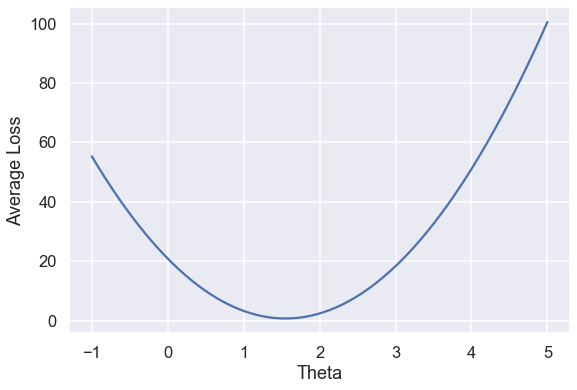

In [7]:
def visualize(x, y, thetas):
    """
    Plots the average l2 loss for given x, y as a function of theta.
    Use the functions you wrote for linear_model and l2_loss.

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    thetas -- an array containing different estimates of the scalar theta
    """ 
    avg_loss = np.array([average_squared_loss(linear_model(x, theta), y) for theta in thetas])
    plt.figure(figsize=(8,6))
    plt.plot(thetas, avg_loss)
    plt.xlabel("Theta")
    plt.ylabel("Average Loss")
    
thetas = np.linspace(-1, 5, 70)
visualize(x, y, thetas)

You should notice that $\hat{\theta}$ is approximately 1.5. 

---
## Fitting our Simple Model
Now that we have defined a simple linear model and loss function, let's begin working on fitting our model to the data.

### Question 1
Let's confirm our visual findings for the optimal $\hat{\theta}$.

Recall from homework 5 that the analytical solution for the optimal $\hat{\theta}$ for the average squared loss is: 

$$\hat{\theta} = \frac{\sum_{i=1}^n x_i y_i}{\sum_{i=1}^n x_i^2}$$

Now that we have the analytic solution for $\hat{\theta}$, implement the function `find_theta` that calculates the numerical value of $\hat{\theta}$ based on our data $\textbf{x}$, $\textbf{y}$.

<!--
BEGIN QUESTION
name: q1
points: 1
-->

In [8]:
def find_theta(x, y):
    """
    Find optimal theta given x and y

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    """
    return sum(x*y)/sum(x**2)

theta_hat_simple = find_theta(x, y)
print(f'theta_hat = {theta_hat_simple}')

theta_hat = 1.5502648085962218


In [9]:
grader.check("q1")

q1 passed!

Now, let's plot our risk function again using the `visualize` function. But this time, we will add a vertical line at the optimal value of theta (plot the line $\theta = \hat{\theta}$).

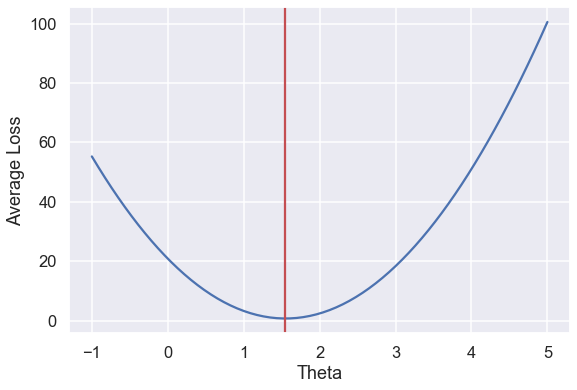

In [10]:
theta_opt = find_theta(x, y)
visualize(x, y, thetas)
plt.axvline(x=theta_opt, color='r');

We now have an optimal value for $\theta$ that minimizes the empirical risk. We can use the scatter plot of the data and add the line $f_{\hat{\theta}}(x) = \hat{\theta} \cdot \textbf{x}$ using the $\hat{\theta}$ computed above.

C:\Users\John8\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\John8\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\John8\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


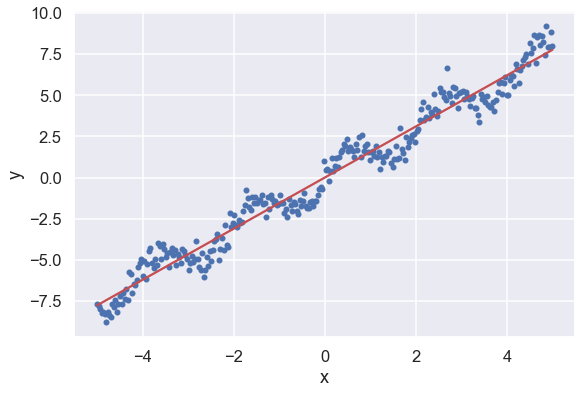

In [11]:
theta_opt_2 = find_theta(x, y)
scatter(x, y)
line_values = linear_model(x, theta_opt_2)
plt.plot(x, line_values, color='r');

Great! It looks like our estimator $f_{\hat{\theta}}(x)$ is able to estimate the average $y$ for each $x$ quite well using a single parameter $\theta$. 

The difference between the true $y$'s and the predictions is known as the residual, $\textbf{r}=\textbf{y}-\hat{\theta} \cdot \textbf{x}$. Below, we find the residual and plot the residuals corresponding to $x$ in a scatter plot. We also plot a horizontal line at $y=0$ to assist visualization.

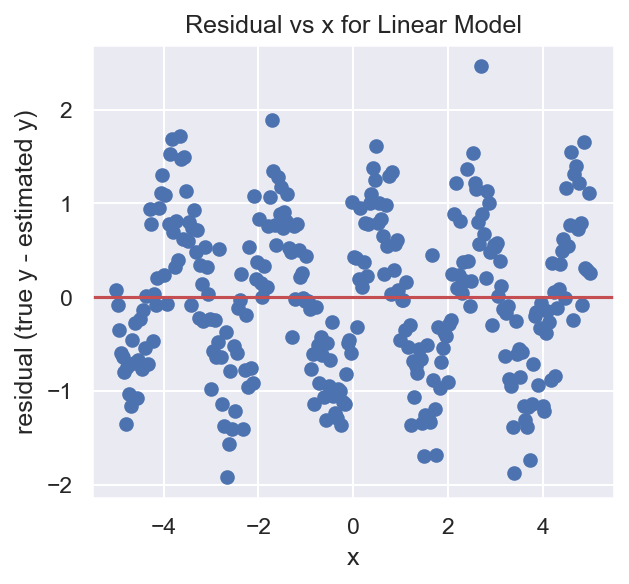

In [218]:
def visualize_residual(x, y):
    """
    Plot a scatter plot of the residuals, the remaining 
    values after removing the linear model from our data.

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    """
    ...
    theta_hat = find_theta(x, y)
    y_sin = y - linear_model(x, theta_hat)
    plt.scatter(x, y_sin)
    plt.xlabel('x')
    plt.ylabel('residual (true y - estimated y)')
    plt.title('Residual vs x for Linear Model')
    plt.axhline(y=0, color='r')

visualize_residual(x, y)

## 2: Increasing Model Complexity

It looks like the residual is sinusoidal, meaning our original data follows a linear function and a sinusoidal function. Let's define a new model to address this discovery and find optimal parameters to best fit the data:

$$\Large
f_\boldsymbol\theta(x) = \theta_1x + sin(\theta_2x)
$$

Now, our model is parameterized by both $\theta_1$ and $\theta_2$, which we can represent in the vector, $\boldsymbol{\theta}$.

Note that a general sine function $a\sin(bx+c)$ has three parameters: amplitude scaling parameter $a$, frequency parameter $b$ and phase shifting parameter $c$. Looking at the residual plot above, it looks like the residual is zero at x = 0, and the residual swings between -1 and 1. Thus, it seems reasonable to effectively set the scaling and phase shifting parameter ($a$ and $c$ in this case) to 1 and 0 respectively. While we could try to fit $a$ and $c$, we're unlikely to get much benefit. When you're done with this assignment, you can try adding $a$ and $c$ to our model and fitting these parameters to see if you can get a better loss.

We define the `sin_model` function below that predicts $\textbf{y}$ (the $y$-values) using $\textbf{x}$ (the $x$-values) based on our new equation.

In [13]:
def sin_model(x, theta):
    """
    Predict the estimate of y given x, theta_1, theta_2

    Keyword arguments:
    x -- the vector of values x
    theta -- a vector of length 2, where theta[0] = theta_1 and theta[1] = theta_2
    """
    theta_1 = theta[0]
    theta_2 = theta[1]
    return theta_1 * x + np.sin(theta_2 * x)

<!-- BEGIN QUESTION -->

#### Question 2a

Recall the optimal value of $\theta$ should minimize our loss function. One way we've approached solving for $\theta$ is by taking the derivative of our loss function with respect to $\theta$, like we did in HW5.  

Write/derive the expressions for following values and write them with LaTeX in the space below.

* $R(\textbf{x}, \textbf{y}, \theta_1, \theta_2)$: our loss function, the empirical risk/mean squared error
* $\frac{\partial R }{\partial \theta_1}$: the partial derivative of $R$ with respect to $\theta_1$
* $\frac{\partial R }{\partial \theta_2}$: the partial derivative of $R$ with respect to $\theta_2$

Recall that $R(\textbf{x}, \textbf{y}, \theta_1, \theta_2) = \frac{1}{n} \sum_{i=1}^{n} (\textbf{y}_i - \hat{\textbf{y}_i})^2$

<!--
BEGIN QUESTION
name: q2a
manual: True
points: 2
-->

* $R(\textbf{x}, \textbf{y}, \theta_1, \theta_2) =  \frac{1}{n}\sum_{i=1}^{n}(y-\theta_1x-\sin(\theta_2x))^2$
* $\frac{\partial R }{\partial \theta_1} = \frac{1}{n}\cdot-2\sum_{i=1}^{n}(y-\theta_1x-\sin(\theta_2x))x$
* $\frac{\partial R }{\partial \theta_2} = \frac{1}{n}\cdot2\sum_{i=1}^{n}(y-\theta_1x-\theta_2x)\cos x$

<!-- END QUESTION -->

#### Question 2b
Now, implement the functions `sin_MSE`, `sin_MSE_dt1` and `sin_MSE_dt2`, which should compute $R$, $\frac{\partial R }{\partial \theta_1}$ and $\frac{\partial R }{\partial \theta_2}$ respectively. Use the expressions you wrote for $\frac{\partial R }{\partial \theta_1}$ and $\frac{\partial R }{\partial \theta_2}$ in the previous exercise. In the functions below, the parameter `theta` is a vector that looks like $( \theta_1, \theta_2 )$. We have completed `sin_MSE_gradient` for you.

Notes: 
* Keep in mind that we are still working with our original set of data, `part_1_data`
* To keep your code a bit more concise, be aware that `np.mean` does the same thing as `np.sum` divided by the length of the numpy array.

<!--
BEGIN QUESTION
name: q2b
points: 2
-->

In [219]:
(y-np.pi*x-np.sin(2*x))*np.cos(x)

0      2.125093
1      1.844663
2      1.548876
3      1.271605
4      1.042083
         ...   
295   -0.887013
296   -1.326324
297   -1.562039
298   -1.585696
299   -2.029152
Length: 300, dtype: float64

In [220]:
def sin_MSE(theta):
    """
    Compute the numerical value of the l2 loss of our sinusoidal model given theta

    Keyword arguments:
    theta -- the vector of values theta
    """
    return sum((y-theta[0]*x-np.sin(theta[1]*x))**2) / (len(y))

def sin_MSE_dt1(theta):
    """
    Compute the numerical value of the partial of l2 loss with respect to theta_1

    Keyword arguments:
    theta -- the vector of values theta
    """
    return sum((y-theta[0]*x-np.sin(theta[1]*x))*x) / (len(y)) * (-2)
    
def sin_MSE_dt2(theta):
    """
    Compute the numerical value of the partial of l2 loss with respect to theta_2

    Keyword arguments:
    theta -- the vector of values theta
    """
    return sum((y-theta[0]*x-np.sin(theta[1]*x))*np.cos(theta[1]*x)*x) / (len(y)) * (-2)
    
# This function calls dt1 and dt2 and returns the gradient dt. It is already implemented for you.
def sin_MSE_gradient(theta):
    """
    Returns the gradient of l2 loss with respect to vector theta

    Keyword arguments:
    theta -- the vector of values theta
    """
    x = part_1_data['x']
    y = part_1_data['y']     
    return np.array([sin_MSE_dt1(theta), sin_MSE_dt2(theta)])

In [222]:
sin_MSE_dt2([0, np.pi])

1.9427210155296568

In [221]:
grader.check("q2b")

q2b passed!

## 3: Gradient Descent

In lecture, we saw that there are a number of ways to optimize a linear model:

1. Brute force guess and check
2. Analytically derive a closed form solution
3. Use a numerical method like gradient descent

You can try to solve for the optimal $\hat{\mathbf{\theta}}$ analytically using your answers from 2a, but we don't recommend it. Notably, observe that the model is not even linear, e.g. it contains $\theta_2$ inside a sine function.

To demonstrate how truly powerful techniques like gradient descent are, we'll use it in this assignment to optimize our nonlinear model.

### Question 3

Let's now implement gradient descent. 

Note that the function you're implementing here is somewhat different than the gradient descent function we created in lecture. The version in lecture was `gradient_descent(df, initial_guess, alpha, n)`, where `df` was the gradient of the function we are minimizing and `initial_guess` are the starting parameters for that function. Here our signature is a bit different (described below).

#### Question 3a
Implement the `grad_desc` function that performs gradient descent for a finite number of iterations. This function takes in an array for $\textbf{x}$ (`x`), an array for $\textbf{y}$ (`y`), and an initial value for $\theta$ (`theta`). `alpha` will be the learning rate (or step size, whichever term you prefer). In this part, we'll use a static learning rate (i.e. the same learning rate at every time step), just like in lecture.

At each time step, use the gradient and `alpha` to update your current `theta`. Also at each time step, be sure to save the current `theta` in `theta_history`, along with the average squared loss (computed with the current `theta`) in `loss_history`.

After completing the function, the cell will output the trajectory from running gradient descent over time.

Hints:
- Write out the gradient update equation (1 step). What variables will you need for each gradient update? Of these variables, which ones do you already have, and which ones will you need to recompute at each time step?
- You may need a loop here to update `theta` several times.
- Recall that the gradient descent update function follows the form:
$$\large
\boldsymbol\theta^{(t+1)} \leftarrow \boldsymbol\theta^{(t)} - \alpha \left(\nabla_\boldsymbol\theta \mathbf{R}(\textbf{x}, \textbf{y}, \boldsymbol\theta^{(t)}) \right)
$$
- Be sure to include the initial theta and loss into the trajectory because the test checks for this.

<!--
BEGIN QUESTION
name: q3a
points: 2
-->

In [54]:
def init_theta():
    """Creates an initial theta [0, 0] of shape (2,) as a starting point for gradient descent"""
    return np.zeros((2,))

def grad_desc(loss_f, gradient_loss_f, theta, num_iter=20, alpha=0.1):
    """
    Run gradient descent update for a finite number of iterations and static learning rate

    Keyword arguments:
    loss_f -- the loss function to be minimized (used for computing loss_history)
    gradient_loss_f -- the gradient of the loss function to be minimized
    theta -- the vector of values theta to use at first iteration
    num_iter -- the max number of iterations
    alpha -- the learning rate (also called the step size)
    
    Return:
    theta -- the optimal value of theta after num_iter of gradient descent
    theta_history -- the series of theta values over each iteration of gradient descent
    loss_history -- the series of loss values over each iteration of gradient descent
    """
    theta_history = []
    loss_history = []
    
    for i in range(num_iter+1):
        loss_history.append(sin_MSE(theta))
        theta = theta - alpha*sin_MSE_gradient(theta)
        theta_history.append(theta)
        
    return theta, theta_history, loss_history

theta_start = init_theta()
theta_hat, thetas_used, losses_calculated = grad_desc(sin_MSE, sin_MSE_gradient, theta_start, num_iter=20, alpha=0.1)
for b, l in zip(thetas_used, losses_calculated):
    print(f"theta: {b}, Loss: {l}")

theta: [2.6011 2.6011], Loss: 20.85919141642223
theta: [0.9034 2.591 ], Loss: 9.28500817304868
theta: [2.0563 2.9631], Loss: 4.680169273815354
theta: [1.1589 2.8669], Loss: 2.624251793632574
theta: [1.7939 3.0728], Loss: 1.4765157174727765
theta: [1.3216 3.0015], Loss: 0.9073271435862453
theta: [1.6495 3.0291], Loss: 0.5415316432911288
theta: [1.4233 2.9882], Loss: 0.37758411424694854
theta: [1.583  3.0103], Loss: 0.29697506881307606
theta: [1.471  2.9893], Loss: 0.25904254213757355
theta: [1.5504 3.0017], Loss: 0.23973439443291866
theta: [1.4944 2.9914], Loss: 0.23034782416254643
theta: [1.5342 2.998 ], Loss: 0.2255775832667725
theta: [1.506  2.9929], Loss: 0.22321772191904082
theta: [1.526  2.9963], Loss: 0.22202363967204036
theta: [1.5119 2.9938], Loss: 0.22142811500262408
theta: [1.5219 2.9955], Loss: 0.22112776381775162
theta: [1.5148 2.9942], Loss: 0.22097741373654567
theta: [1.5198 2.9951], Loss: 0.22090173185683037
theta: [1.5163 2.9945], Loss: 0.22086378105845872
theta: [1.518

In [55]:
grader.check("q3a")

q3a passed!

#### Question 3b
Now, let's try using a decaying learning rate. Implement `grad_desc_decay` below, which performs gradient descent with a learning rate that decreases slightly with each time step. You should be able to copy most of your work from the previous part, but you'll need to tweak how you update `theta` at each time step.

By decaying learning rate, we mean instead of just a number $\alpha$, the learning should be now $\frac{\alpha}{i+1}$ where $i$ is the current number of iteration. (Why do we need to add a '+ 1' in the denominator?)

**Note:** Be sure to include the initial theta and loss into the trajectory because the test checks for this.

<!--
BEGIN QUESTION
name: q3b
points: 2
-->

In [56]:
def init_theta():
    """Creates an initial theta [0, 0] of shape (2,) as a starting point for gradient descent"""
    return np.zeros((2,))

def grad_desc_decay(loss_f, gradient_loss_f, theta, num_iter=20, alpha=0.1):
    """
    Run gradient descent update for a finite number of iterations and decaying learning rate

    Keyword arguments:
    loss_f -- the loss function to be minimized (used for computing loss_history)
    gradient_loss_f -- the gradient of the loss function to be minimized
    theta -- the vector of values theta to use at first iteration
    num_iter -- the max number of iterations
    alpha -- the learning rate (also called the step size)
    
    Return:
    theta -- the optimal value of theta after num_iter of gradient descent
    theta_history -- the series of theta values over each iteration of gradient descent,
                     should include the starting and ending theta (i.e. num_iter + 1 items)
    loss_history -- the series of loss values over each iteration of gradient descent, 
                     should include the starting and ending theta (i.e. num_iter + 1 items)
    """
    theta_history = []
    loss_history = []
    for i in range(num_iter+1):
        loss_history.append(sin_MSE(theta))
        theta = theta - alpha*sin_MSE_gradient(theta)/(i+1)
        theta_history.append(theta)
    return theta, theta_history, loss_history

theta_start = init_theta()
theta_hat_decay, thetas_used_decay, losses_calculated_decay =  grad_desc_decay(sin_MSE, sin_MSE_gradient, theta_start, num_iter=20, alpha=0.1)
for b, l in zip(thetas_used_decay, losses_calculated_decay):
    print(f"theta: {b}, Loss: {l}")

theta: [2.6011 2.6011], Loss: 20.85919141642223
theta: [1.7522 2.596 ], Loss: 9.28500817304868
theta: [1.6615 2.6585], Loss: 0.9288337694245642
theta: [1.6273 2.7024], Loss: 0.6305856872695188
theta: [1.6087 2.7343], Loss: 0.5179242520135396
theta: [1.5965 2.7586], Loss: 0.45363771946941295
theta: [1.5877 2.7778], Loss: 0.41142903882132176
theta: [1.5811 2.7934], Loss: 0.38153256869715296
theta: [1.5757 2.8064], Loss: 0.35926368186605545
theta: [1.5714 2.8174], Loss: 0.342056588924484
theta: [1.5677 2.8269], Loss: 0.32838086434190333
theta: [1.5646 2.8352], Loss: 0.31726555449704125
theta: [1.5619 2.8425], Loss: 0.3080646558251182
theta: [1.5595 2.849 ], Loss: 0.3003316788186871
theta: [1.5575 2.8549], Loss: 0.2937482120787365
theta: [1.5556 2.8602], Loss: 0.2880811398950519
theta: [1.5539 2.865 ], Loss: 0.2831559330512717
theta: [1.5524 2.8693], Loss: 0.27883937959562793
theta: [1.551  2.8734], Loss: 0.2750280789874102
theta: [1.5498 2.8771], Loss: 0.2716405740106778
theta: [1.5486 2.

In [57]:
grader.check("q3b")

q3b passed!

Let's visually inspect our results of running gradient descent to optimize $\boldsymbol\theta$. The code below plots our $x$-values with our model's predicted $\hat{y}$-values over the original scatter plot. You should notice that gradient descent successfully optimized $\boldsymbol\theta$.

In [58]:
theta_init = init_theta()
theta_est, thetas, loss = grad_desc(sin_MSE, sin_MSE_gradient, theta_init)

theta_init = init_theta()
theta_est_decay, thetas_decay, loss_decay = grad_desc_decay(sin_MSE, sin_MSE_gradient, theta_init)

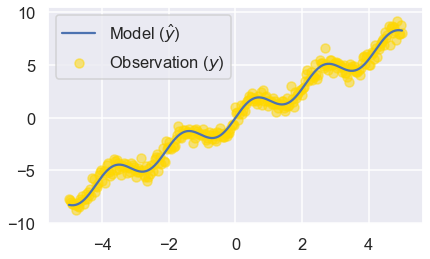

In [59]:
y_pred = sin_model(x, theta_est)

plt.plot(x, y_pred, label='Model ($\hat{y}$)')
plt.scatter(x, y, alpha=0.5, label='Observation ($y$)', color='gold')
plt.legend();

Run the following cell to see a plot of the loss values over each iteration of gradient descent for both static learning rate and decaying learning rate. 

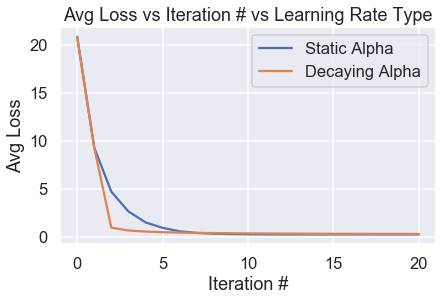

In [60]:
plt.plot(np.arange(len(loss)), loss, label='Static Alpha')
plt.plot(np.arange(len(loss)), loss_decay, label='Decaying Alpha')
plt.xlabel('Iteration #')
plt.ylabel('Avg Loss')
plt.title('Avg Loss vs Iteration # vs Learning Rate Type')
plt.legend();

---
## Visualizing Loss
Let's visualize our loss functions and gain some insight as to how gradient descent optimizes our model parameters.

In the previous plot we saw the loss decrease with each iteration. In this part, we'll see the trajectory of the algorithm as it travels the loss surface? Run the following cells to see visualization of this trajectory. 

In [61]:
thetas = np.array(thetas).squeeze()
thetas_decay = np.array(thetas_decay).squeeze()
loss = np.array(loss)
loss_decay = np.array(loss_decay)
thetas

array([[2.6011, 2.6011],
       [0.9034, 2.591 ],
       [2.0563, 2.9631],
       [1.1589, 2.8669],
       [1.7939, 3.0728],
       [1.3216, 3.0015],
       [1.6495, 3.0291],
       [1.4233, 2.9882],
       [1.583 , 3.0103],
       [1.471 , 2.9893],
       [1.5504, 3.0017],
       [1.4944, 2.9914],
       [1.5342, 2.998 ],
       [1.506 , 2.9929],
       [1.526 , 2.9963],
       [1.5119, 2.9938],
       [1.5219, 2.9955],
       [1.5148, 2.9942],
       [1.5198, 2.9951],
       [1.5163, 2.9945],
       [1.5188, 2.9949]])

In [62]:
# Run me to see a 3D plot (gradient descent with static alpha)
plot_3d(thetas[:, 0], thetas[:, 1], loss, average_squared_loss, sin_model, x, y)

In [63]:
# Run me to see another 3D plot (gradient descent with decaying alpha)
plot_3d(thetas_decay[:, 0], thetas_decay[:, 1], loss_decay, average_squared_loss, sin_model, x, y)

Another common way of visualizing 3D dynamics is with a _contour_ plot. Run the following cells.

In [64]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [65]:
def contour_plot(title, theta_history, loss_function, model, x, y):
    """
    The function takes the following as argument:
        theta_history: a (N, 2) array of theta history
        loss: a list or array of loss value
        loss_function: for example, l2_loss
        model: for example, sin_model
        x: the original x input
        y: the original y output
    """
    theta_1_series = theta_history[:,0] # a list or array of theta_1 value
    theta_2_series = theta_history[:,1] # a list or array of theta_2 value

    ## In the following block of code, we generate the z value
    ## across a 2D grid
    theta1_s = np.linspace(np.min(theta_1_series) - 0.1, np.max(theta_1_series) + 0.1)
    theta2_s = np.linspace(np.min(theta_2_series) - 0.1, np.max(theta_2_series) + 0.1)

    x_s, y_s = np.meshgrid(theta1_s, theta2_s)
    data = np.stack([x_s.flatten(), y_s.flatten()]).T
    ls = []
    for theta1, theta2 in data:
        l = loss_function(model(x, np.array([theta1, theta2])), y)
        ls.append(l)
    z = np.array(ls).reshape(50, 50)
    
    # Create trace of theta point
    # Create the contour 
    theta_points = go.Scatter(name="theta Values", 
                              x=theta_1_series, 
                              y=theta_2_series,
                              mode="lines+markers")
    lr_loss_contours = go.Contour(x=theta1_s, 
                                  y=theta2_s, 
                                  z=z, 
                                  colorscale='Viridis', reversescale=True)

    plotly.offline.iplot(go.Figure(data=[lr_loss_contours, theta_points], layout={'title': title}))

In [66]:
contour_plot('Gradient Descent with Static Learning Rate', thetas, average_squared_loss, sin_model, x, y)

In [67]:
contour_plot('Gradient Descent with Decay Learning Rate', thetas_decay, average_squared_loss, sin_model, x, y)

### Question 3c: Analyzing Learning Rates

<!-- BEGIN QUESTION -->

In 1-2 sentences, describe what you notice about the path that theta takes with a static learning rate vs. a decaying learning rate. In your answer, refer to either pair of plots above (the 3d plot or the contour plot).

<!--
BEGIN QUESTION
name: q3c
manual: true
points: 1
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



# Part 2: Logistic Regression

In this part of the assignment we will fit a logistic regression model on NBA data.

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3
sns.set() 

In [69]:
df = pd.read_csv('nba.csv')
df["WON"] = df["WL"]
df["WON"] = df["WON"].replace("W", 1)
df["WON"] = df["WON"].replace("L", 0)
df.head(5)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,WON
0,22018,1610612744,GSW,Golden State Warriors,21800002,2018-10-16,GSW vs. OKC,W,240,42,...,58,28,7,7,21,29,108,8,1,1
1,22018,1610612760,OKC,Oklahoma City Thunder,21800002,2018-10-16,OKC @ GSW,L,240,33,...,45,21,12,6,15,21,100,-8,1,0
2,22018,1610612755,PHI,Philadelphia 76ers,21800001,2018-10-16,PHI @ BOS,L,240,34,...,47,18,8,5,16,20,87,-18,1,0
3,22018,1610612738,BOS,Boston Celtics,21800001,2018-10-16,BOS vs. PHI,W,240,42,...,55,21,7,5,15,20,105,18,1,1
4,22018,1610612750,MIN,Minnesota Timberwolves,21800010,2018-10-17,MIN @ SAS,L,240,39,...,46,20,9,2,11,27,108,-4,1,0


## Question 4: 1D Logistic Regression Model

In lecture we buit a logistic regression classifier for the NBA data loaded above. Specifically, our model took an observation $x$ and a parameter vector $\theta$ and used them to generate a prediction $\hat{y}$. Note that in this question we will assume that $x$ is a one-dimensional scalar.

In this case, our predictions represented the probability that the observation belonged to a specific category. In lecture the category was whether or not the team won. That is, $\hat{y} = P(Y = 1 | x)$, where $Y = 1$ indicates that the team we're observing won the game.

### Question 4a: Implementing a 1D Logistic Model

As discussed in lecture, the prediction of our model is $ \hat{y} = \sigma(x \hat{\theta})$. _Note: Here, both $x$ and $\hat{\theta}$ are scalars, not vectors._ 

In this part of the assignment we'll start by trying to build a model that predicts the winning probability as a function of the number of points that a team scored.

Below, first define `sigma` to be the sigmoid function we saw in lecture. Then, fill in `predicted_probability_of_winning_given_pts` so that it returns the correct prediction. Your function should work for both scalar and array arguments for `pts`. That is, `predicted_probability_of_winning_given_pts(100, 0.01)` should return a single value `(0.731)` and `predicted_probability_of_winning_given_pts(np.array([100, 110])), 0.01)` should return an array of values `(0.731, 0.750)`. 

<!--
BEGIN QUESTION
name: q4a
points: 1
-->

In [72]:
np.exp(2)

7.38905609893065

In [73]:
def sigma(t):
    return 1 / (1+np.exp(-t))

def predicted_probability_of_winning_given_pts(pts, theta):
    return sigma(pts*theta)

In [74]:
grader.check("q4a")

q4a passed!

### Exploring an Example Model

Suppose we pick $\hat{\theta}$ = 0.01. We can generate predictions for each of the games in our real world dataset as follows:

In [75]:
theta = 0.01
x = df["PTS"]
y_obs = df["WON"]
y_hat = predicted_probability_of_winning_given_pts(x, theta)

If we look at our predictions, we see that every team is given a greater than 50 percent prediction of winning based on their number of points. This suggests a problem with our model.

In [76]:
y_hat.mean()

0.7517679619807056

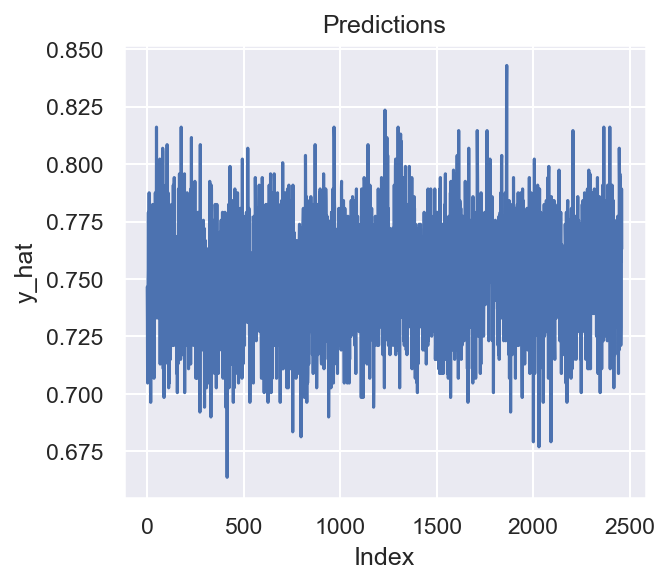

In [77]:
plt.plot(y_hat)
plt.xlabel("Index")
plt.ylabel("y_hat")
plt.title("Predictions");

To understand what's going on, we make a plot of the prediction our model will make as a function of the number of points scored for $\hat{\theta} = 0.01$. 

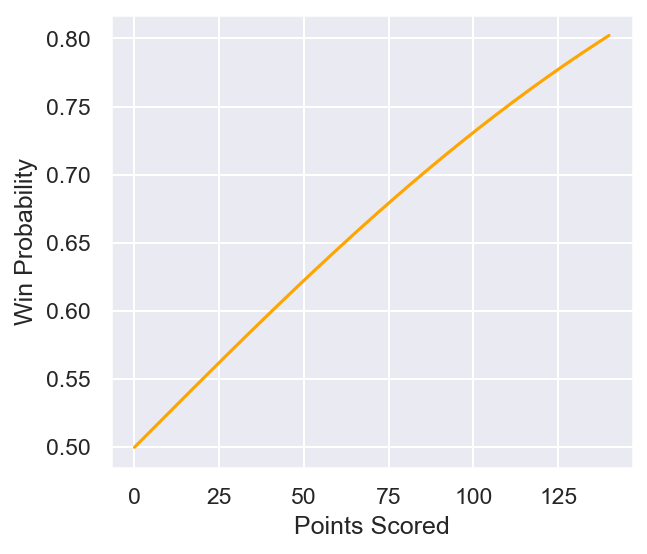

In [78]:
theta = 0.01
pts = np.linspace(0, 140, 140)
plt.plot(pts, predicted_probability_of_winning_given_pts(pts, theta), color = 'orange')
plt.ylabel("Win Probability")
plt.xlabel("Points Scored");

We can also provide the actual results from the NBA dataset as blue stars for comparison to our model.

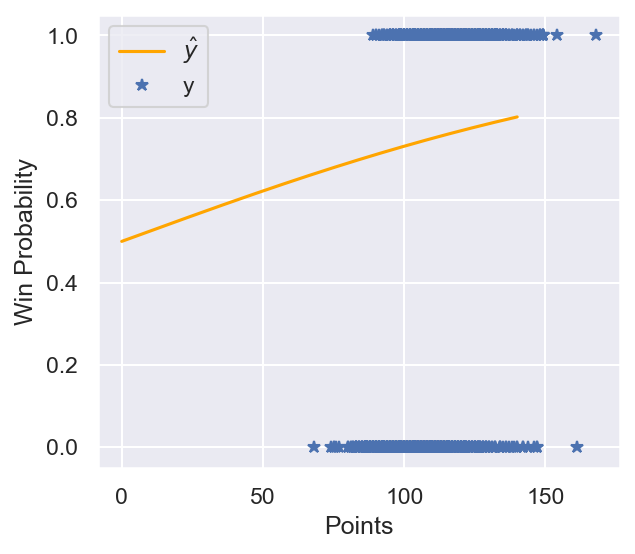

In [79]:
theta = 0.01
pts = np.linspace(0, 140, 140)
plt.plot(pts, predicted_probability_of_winning_given_pts(pts, theta), color = 'orange')
plt.plot(df[["PTS"]], df[["WON"]], 'b*')
plt.ylabel("Win Probability")
plt.xlabel("Points")
plt.legend(['$\hat{y}$', 'y']);

<!-- BEGIN QUESTION -->

### Question 4b

<!--
BEGIN QUESTION
name: q4b
manual: true
points: 1
-->

Is this model reasonable? Why or why not?

Not reasonable.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 4c

Try playing around with other theta values. You should observe that the models are all pretty bad, no matter what $\theta$ you pick. Explain why below.

<!--
BEGIN QUESTION
name: q4c
manual: true
points: 1
-->

_Data has bias but model hasn't._

<!-- END QUESTION -->



## Question 5: Adding an Intercept Term

If you observe your plot(s) from the previous question, you'll see that the chance of winning is always at least 0.5 under our model (assuming $\hat{\theta} \geq 0$). This is unreasonable, e.g. suppose a team somehow scored only 36 points, they'd have no chance of winning in an NBA game.

### Implementing Logistic Regression with an Intercept Term

To deal with this, we should add another feature to our model. Specifically, we'll add a bias term, i.e. a feature that is equal to 1 for all observations. We've done this for you below.

In [80]:
points_and_bias = df[["PTS"]].copy()
points_and_bias["bias"] = np.ones(len(points_and_bias))
points_and_bias.head()

,PTS,bias
0,108,1.0
1,100,1.0
2,87,1.0
3,105,1.0
4,108,1.0


Logistic regression generalizes to multiple features in exactly the same manner as linear regression.

Recall that whereas linear regression on one parameter gave predictions $\hat{y} = x \hat{\theta}$, multiple linear regression gave predictions $\hat{y} = \vec{x} \cdot \vec{\hat{\theta}} = \vec{x}^T \vec{\hat{\theta}} = \sum_{i = 1}^p x_i \hat{\theta}_i$.

Logistic regression generalizes in exactly the same way. That is logistic regression in 1 variable is given by $\hat{y} = \sigma(x \hat{\theta})$, whereas multiple logistic regression is given by $\hat{y} = \sigma(\vec{x} \cdot \vec{\hat{\theta}}) = \sigma(\vec{x}^T \vec{\hat{\theta}}) = \sigma(\sum_{i = 1}^p x_i \hat{\theta}_i)$.

Fill in the function below so that it returns predictions as described above. As in the previous question, your model should be able to handle scalar and array arguments for x. For example `predicted_probability_of_winning_given_features(X.iloc[0:3, :], [0.1, -10])` should return a list, series, or numpy array of the values `[0.6899744811276126, 0.5, 0.21416501695744153]`.

Your function only needs to work for array inputs to `x`. That is, your code does not need to work properly for `predicted_probability_of_winning_given_features(110, [0.1, -10])`

In [85]:
def predicted_probability_of_winning_given_features(X, theta):
    return sigma(X @ theta)

In [86]:
grader.check("q5a")

q5a passed!

### Exploring Logistic Regression with an Intercept Term

Now we have two parameters $\theta_1$ and $\theta_2$. Suppose $\theta_1 = 0.001$ and $\theta_2 = 2$. We can compute the predicted probability that each team won during each game as follows.

In [87]:
theta = np.array([0.001, 2])
predicted_probability_of_winning_given_features(points_and_bias.iloc[0:3, :], theta)

0    0.891678
1    0.890903
2    0.889633
dtype: float64

In [88]:
points_and_bias.iloc[0:3, :]

,PTS,bias
0,108,1.0
1,100,1.0
2,87,1.0


Now that we have a bias term, we have more freedom to adjust our model.

For example, if $\theta_1 = 0.05$ and $\theta_2 = -5$, we get the curve below. Here, the prediction of your model is $\sigma(\theta_1 \times \text{PTS} + \theta_2)$. That is, $\theta_1$ is the weight of `PTS`, and $\theta_2$ is the weight of the bias term.

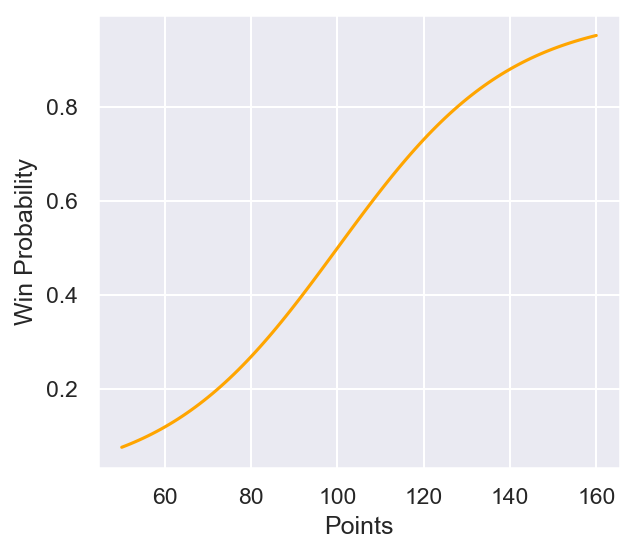

In [89]:
theta = [0.05, -5]
pts = np.linspace(50, 160, 111).reshape(-1, 1)
bias = np.ones(len(pts)).reshape(-1, 1)
point_range_and_bias = np.hstack((pts, bias))
plt.plot(pts, predicted_probability_of_winning_given_features(point_range_and_bias, theta), 'orange')
plt.ylabel("Win Probability")
plt.xlabel("Points");

And as before, we can also plot the actual data from our NBA dataset for comparison with our model.

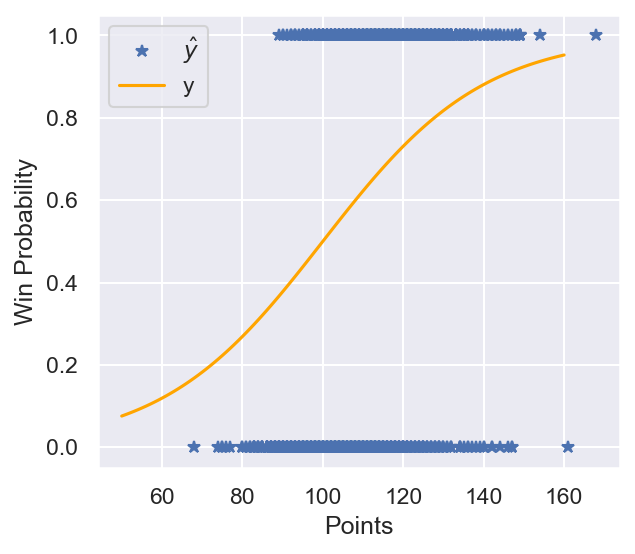

In [102]:
plt.plot(df["PTS"], df["WON"], 'b*')
theta = [0.05, -5]
pts = np.linspace(50, 160, 111).reshape(-1, 1)
bias = np.ones(len(pts)).reshape(-1, 1)
point_range_and_bias = np.hstack((pts, bias))
plt.plot(pts, predicted_probability_of_winning_given_features(point_range_and_bias, theta), 'orange')
plt.ylabel("Win Probability")
plt.xlabel("Points")
plt.legend(['$\hat{y}$', 'y']);

<!-- BEGIN QUESTION -->

### Question 5b

<!--
BEGIN QUESTION
name: q5b
manual: true
points: 1
-->
Using the plot above, try adjusting $\theta_2$ (only). Describe how changing $\theta_2$ affects the prediction curve. Provide your description in the cell below.

when $\theta_2$ ascends, y asecnds, and vice versa.

<!-- END QUESTION -->



### Question 5c
Now using the plot below try adjusting $\theta_1$ and $\theta_2$ such that you get a sharp curve that is centered at 100 points. In the cell below `theta` should be a list with your chosen values of $\theta_1$ and $\theta_2$.

- By "centered at 100 points", we mean that $\hat{y}$ should be equal to 0.5 when $x = 100$.
- By "sharp", we mean that the probability should be less than 5% percent for $x = 80$, and greater than 95% for $x = 120$.
- *Hint*: $\sigma(t) = 0.5$ when $t = 0$.

In [130]:
sigma(-np.log(19.001))

0.04999750012499376

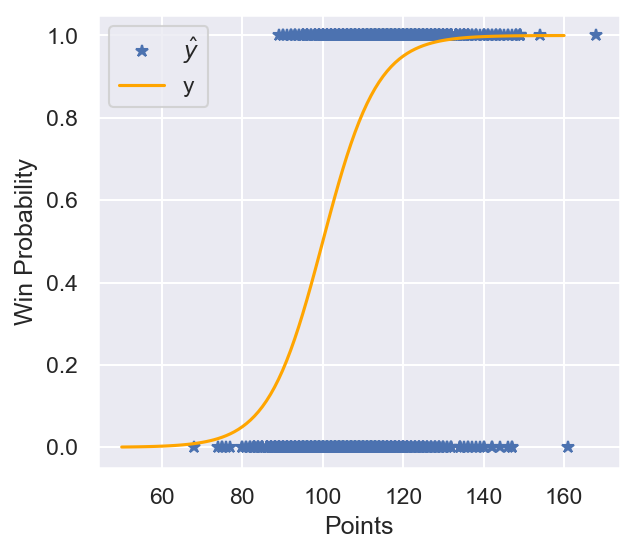

In [127]:
plt.plot(df["PTS"], df["WON"], 'b*')
theta = [np.log(19.001)/20, -5*np.log(19.001)]
pts = np.linspace(50, 160, 111).reshape(-1, 1)
bias = np.ones(len(pts)).reshape(-1, 1)
point_range_and_bias = np.hstack((pts, bias))
plt.plot(pts, predicted_probability_of_winning_given_features(point_range_and_bias, theta), 'orange')
plt.ylabel("Win Probability")
plt.xlabel("Points")
plt.legend(['$\hat{y}$', 'y']);

Provide your $\theta_1$ and $\theta_2$ in the cell below.
<!--
BEGIN QUESTION
name: q5c
points: 1
-->

$\begin{cases}\sigma(t_1)=0.5\rightarrow t_1=0\\\sigma(t_2)=0.05\rightarrow t_2=-\ln(19)\end{cases}\\
\begin{cases}\begin{bmatrix}100 & 1\end{bmatrix}\begin{bmatrix}\theta_1 \\ \theta_2\end{bmatrix}=0\\\begin{bmatrix}80 & 1\end{bmatrix}\begin{bmatrix}\theta_1 \\ \theta_2\end{bmatrix}=-\ln(19)\end{cases}\rightarrow\begin{cases}\theta_1=\ln(19)/20\\\theta_2=-5\ln(19)\end{cases}$

In [128]:
theta1 = np.log(19.001)/20
theta2 = -5*np.log(19.001)

In [129]:
grader.check("q5c")

q5c passed!

## Question 6: Optimizing Logistic Regresion

Let's now work towards finding the optimal theta $\hat{\theta}$ for our given data.

_Note: In the previous question, we referred to our $\theta$s without a hat, since we had yet to find the optimal values of $\theta$ procedurally._

### Question 6a: Calculating MSE

Create a function `mse_for_model_on_NBA_data(theta)` that takes in a value of $\theta$ and returns the MSE on the dataset from above. You will first need to define the function `mse(y_obs, y_hat)` which finds the mean squared error between `y_obs` and `y_hat`.

**Hint:** You need to compute $\hat{y}$ using the given $\theta$, then the mean squared error between $\hat{y}$ and the observed data $y$.

**Hint:** Use `points_and_bias` and `df["WON"]`.

In [147]:
def mse(y_obs, y_hat):
    return sum((y_obs-y_hat)**2) / len(y_hat)

def mse_for_model_on_NBA_data(theta):
    return mse(df['WON'], sigma(points_and_bias @ theta))

In [149]:
grader.check("q6a")

q6a passed!

### Plotting MSE

The cell below plots your MSE function. We're providing this plot purely for your edification. Warning: This code can be pretty slow and might take a minute or two to run.

Note that the surface has a huge almost completely flat region. This means this loss function is very difficult to optimize.

In [150]:
import plotly.graph_objects as go

num_points = 50 # increase for better resolution, but it will run more slowly. 

if (num_points <= 100):

    uvalues = np.linspace(-0.3, 0.3, num_points)
    vvalues = np.linspace(-20, 20, num_points)
    (u,v) = np.meshgrid(uvalues, vvalues)
    thetas = np.vstack((u.flatten(),v.flatten()))

    MSE = np.array([mse_for_model_on_NBA_data(t) for t in thetas.T])

    loss_surface = go.Surface(x=u, y=v, z=np.reshape(MSE, u.shape))

    fig = go.Figure(data=[loss_surface])
    fig.update_layout(scene = dict(
        xaxis_title = "theta0",
        yaxis_title = "theta1",
        zaxis_title = "MSE"))
    fig.show()
else:
    print("Picking num points > 100 can be really slow. If you really want to try, edit the code above so that this if statement doesn't trigger.")

### Question 6b: Minimizing MSE

Using `scipy.optimize.minimize`, find the optimal $\hat{\theta}$.  Give your answer as `theta_hat_1` and `theta_hat_2`. The resulting MSE should be less than 0.2.

Note: Your starting guess should be (0, 0). If you start somewhere over in the flat region like (0, 20), then scipy.optimize.minimize will get stuck.

Note: The test(s) for this question requires that you did the previous part correctly.

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [153]:
from scipy.optimize import minimize

optimal_theta = minimize(mse_for_model_on_NBA_data, x0 = [0,0])
theta_hat_1 = optimal_theta['x'][0]
theta_hat_2 = optimal_theta['x'][1]
theta_hat_1, theta_hat_2

(0.09954490444481055, -11.02797792643433)

In [154]:
grader.check("q6b")

q6b passed!

### Question 6c

Finally, let's try to understand how our model can be practically useful. As we'll see in lecture 19, we often convert our logistic regression models into a concrete prediction by thresholding. That is, if our $\hat{y} \geq 0.5$, we say our prediction is that the team will win; otherwise, we say that we predict that we will lose. A simple way to do this is just to round our $\hat{y}$.

In [155]:
y_hat = predicted_probability_of_winning_given_features(points_and_bias, np.array([theta_hat_1, theta_hat_2])) 
games_and_predictions = df.copy()
games_and_predictions["predicted_to_win"] = np.round(y_hat)
games_and_predictions[["TEAM_NAME", "GAME_DATE", "WON", "predicted_to_win"]].tail(5)

,TEAM_NAME,GAME_DATE,WON,predicted_to_win
2455,Denver Nuggets,2019-04-10,1,0.0
2456,Orlando Magic,2019-04-10,1,1.0
2457,Charlotte Hornets,2019-04-10,0,1.0
2458,Memphis Grizzlies,2019-04-10,1,1.0
2459,Golden State Warriors,2019-04-10,0,1.0


To evaluate the quality of your model, compute the fraction of the rows of the table for which your model was able to correctly predict the outcome of the game based on only the points scored by one team. Assign this to the variable `percentage_correct`.

<!--
BEGIN QUESTION
name: q6c
points: 1
-->

In [160]:
percentage_correct = 1 - sum(abs(games_and_predictions['WON']-games_and_predictions['predicted_to_win']))/len(df['WON'])
percentage_correct

0.7109756097560975

In [161]:
grader.check("q6c")

q6c passed!

### Question 6d

Recall that the surface for the MSE has a huge almost completely flat region, which means that the loss function is very difficult to optimize.

In lecture we talked about an alternate loss function called the cross-entropy loss that yielded a much nicer loss surface (no big flat regions). You will need to define the function `cel(y_obs, y_hat)` which calculates the cross-entropy loss betweeen `y_obs` and `y_hat`. Then, create a function `cel_for_model_on_NBA_data(theta)` that takes in a value of $\vec{{\theta}}$ and returns the cross-entropy loss on the dataset from the previous question.


**Hint:** Your code for this part should be very similar to your code for part a of this question.

<!--
BEGIN QUESTION
name: q6d
points: 1
-->

In [168]:
def cel(y_obs, y_hat):
    return -y_obs*np.log(y_hat)-(1-y_obs)*np.log(1-y_hat)

def cel_for_model_on_NBA_data(theta):
    return sum(cel(df['WON'], sigma(points_and_bias @ theta))) / len(df['WON'])

In [169]:
cel_for_model_on_NBA_data(np.array([0.01, 2]))

1.5705665042569072

In [170]:
grader.check("q6d")

q6d passed!

### Plotting Cross-Entropy Loss

The cell below plots your cross-entropy loss function. Note that the surface has no big flat regions, which makes it easy to optimize.

Note: Feel free to ignore the divide by zero warning.

In [171]:
import plotly.graph_objects as go

num_points = 50 # increase for better resolution, but it will run more slowly. 

if (num_points <= 100):

    uvalues = np.linspace(-0.3, 0.3, num_points)
    vvalues = np.linspace(-20, 20, num_points)
    (u,v) = np.meshgrid(uvalues, vvalues)
    thetas = np.vstack((u.flatten(),v.flatten()))

    CEL = np.array([cel_for_model_on_NBA_data(t) for t in thetas.T])

    loss_surface = go.Surface(x=u, y=v, z=np.reshape(CEL, u.shape))

    fig = go.Figure(data=[loss_surface])
    fig.update_layout(scene = dict(
        xaxis_title = "theta0",
        yaxis_title = "theta1",
        zaxis_title = "CEL"))
    fig.show()
else:
    print("Picking num points > 100 can be really slow. If you really want to try, edit the code above so that this if statement doesn't trigger.")

C:\Users\John8\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



## Question 7: Higher Dimensional Models

To wrap up this part of the assignment, let's try training a logistic regression model on all useful fields. Note we won't include the difference in the number of points between the two teams (given as PLUS_MINUS), otherwise the logistic regression will be right 100% of the time (since a team wins if and only if PLUS_MINUS > 0).

In [211]:
useful_numeric_fields = df.loc[:, 'FGM':'PTS'].copy()
useful_numeric_fields["BIAS"] = np.ones(len(useful_numeric_fields))
useful_numeric_fields.head(5)

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,BIAS
0,42,95,0.442,7,26,0.269,17,18,0.944,17,41,58,28,7,7,21,29,108,1.0
1,33,91,0.363,10,37,0.270,24,37,0.649,16,29,45,21,12,6,15,21,100,1.0
2,34,87,0.391,5,26,0.192,14,23,0.609,6,41,47,18,8,5,16,20,87,1.0
3,42,97,0.433,11,37,0.297,10,14,0.714,12,43,55,21,7,5,15,20,105,1.0
4,39,91,0.429,6,19,0.316,24,27,0.889,14,32,46,20,9,2,11,27,108,1.0


### Question 7a
Using the ideas from earlier in this part of the assignment, find `theta_19_hat`, which should be a numpy array of length 19 that minimizes the MSE. For this, your starting guess should be a vector of 19 zeros. If you start from a random vector, scipy minimize will probably get stuck. The mean squared error for your model should be less than 0.12. You will need to define a function `mse_for_model_on_full_data(theta)` similar to the `mse_for_model_on_NBA_data(theta)` function earlier in this part of the assignment.

<!--
BEGIN QUESTION
name: q7a
points: 1
-->

In [212]:
def mse_for_model_on_full_data(theta):
    return mse(df['WON'], sigma(useful_numeric_fields @ theta))
theta_19_hat = minimize(mse_for_model_on_full_data, x0=[0]*19)['x']

mse_for_model_on_full_data(theta_19_hat)

0.10736591484231589

In [179]:
grader.check("q7a")

q7a passed!

You should see that `mse_for_model_on_full_data(theta_19_hat)` is less than 0.12.

### Question 7b

Compute `frac_19_correct`, which should be equal to the fraction of predictions which are correct given this new model. You should be able to get at least 84% accuracy.

<!--
BEGIN QUESTION
name: q7b
points: 1
-->

In [180]:
y_hat = predicted_probability_of_winning_given_features(useful_numeric_fields, theta_19_hat)
useful_numeric_fields["predicted_to_win"] = np.round(y_hat)
frac_19_correct = 1 - sum(abs(df['WON']-useful_numeric_fields['predicted_to_win']))/len(df['WON'])
frac_19_correct

0.8434959349593496

In [181]:
grader.check("q7b")

q7b passed!

<!-- BEGIN QUESTION -->

### Question 7c

Look at the coefficients in `theta_19_hat` and identify which of the parameters have the biggest effect on the prediction. For this, you might find `useful_numeric_fields.columns` useful. Which attributes have the biggest positive effect on a team's success? The biggest negative effects? Do the results surprise you?

<!--
BEGIN QUESTION
name: q7c
manual: true
points: 1
-->

In [204]:
pd.DataFrame(data=theta_19_hat, index=useful_numeric_fields.columns[:-1])\
            .rename({0:'$\hat\theta$'}, axis=1)

,$\hat\theta$
FGM,2.139776
FGA,-0.451104
FG_PCT,-21.890483
FG3M,0.931074
FG3A,-0.003566
FG3_PCT,2.724292
FTM,0.890705
FTA,-0.071647
FT_PCT,2.108008
OREB,0.296199


* biggest positive effect: FGM
* biggest negative effect: FG_PCT

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [223]:
grader.check_all()

q1 passed!

q2b passed!

q3a passed!

q3b passed!

q4a passed!

q5a passed!

q5c passed!

q6a passed!

q6b passed!

q6c passed!

q6d passed!

q7a passed!

q7b passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [224]:
# Save your notebook first, then run this cell to export your submission.
grader.export("hw7.ipynb")

UnicodeDecodeError: 'cp950' codec can't decode byte 0xc3 in position 1002582: illegal multibyte sequence